In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import data
from scipy import stats

HAS_SKIMAGE = True
%matplotlib inline

In [2]:
def add_gaussian_noise(image, mean=0, sigma=25):
    row, col = image.shape
    dtype = image.dtype
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy_image = image.astype(np.float32) + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    noisy_image = noisy_image.astype(dtype)
    return noisy_image

def add_salt_and_pepper_noise(image, amount=0.04, salt_vs_pepper=0.5):
    noisy_image = np.copy(image)
    row, col = image.shape
    num_pixels = row * col
    num_salt = int(np.ceil(amount * num_pixels * salt_vs_pepper))
    coords_salt = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[coords_salt[0], coords_salt[1]] = 255
    num_pepper = int(np.ceil(amount * num_pixels * (1.0 - salt_vs_pepper)))
    coords_pepper = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[coords_pepper[0], coords_pepper[1]] = 0 
    return noisy_image

def add_speckle_noise(image, sigma=0.1):
    dtype = image.dtype
    row, col = image.shape
    noise = np.random.normal(0, sigma, (row, col))
    noisy_image = image.astype(np.float32) + image.astype(np.float32) * noise
    noisy_image = np.clip(noisy_image, 0, 255)
    noisy_image = noisy_image.astype(dtype)
    return noisy_image

In [3]:
def detect_noise_and_filter(noisy_image,
                            sp_threshold=0.01, 
                            speckle_corr_threshold=0.5, 
                            block_size=16, 
                            gaussian_ksize=(5,5),
                            median_ksize=5,
                            bilateral_d=9,
                            bilateral_sigma_color=75,
                            bilateral_sigma_space=75):
    img_h, img_w = noisy_image.shape
    num_pixels = img_h * img_w

    num_salt = np.sum(noisy_image == 255)
    num_pepper = np.sum(noisy_image == 0)
    sp_percentage = (num_salt + num_pepper) / num_pixels

    if sp_percentage > sp_threshold:
        noise_type = "Salt & Pepper"
        filter_name = "Median Filter"
        print(f"Detected {noise_type} ({(sp_percentage*100):.2f}% extreme pixels). Applying {filter_name}...")
        filtered_image = cv2.medianBlur(noisy_image, median_ksize)
        return noise_type, filter_name, filtered_image

    local_means = []
    local_vars = []
    block_size = min(block_size, img_h, img_w) 
    
    for r in range(0, img_h - block_size + 1, block_size):
        for c in range(0, img_w - block_size + 1, block_size):
            block = noisy_image[r:r+block_size, c:c+block_size]
            mean = np.mean(block)
            var = np.var(block)
            if var > 1e-4: 
                local_means.append(mean)
                local_vars.append(var)

    if not local_means:
         print("Could not compute local statistics. Defaulting to Gaussian Filter.")
         noise_type = "Undetermined (Defaulting Gaussian)"
         filter_name = "Gaussian Filter"
         filtered_image = cv2.GaussianBlur(noisy_image, gaussian_ksize, 0)
         return noise_type, filter_name, filtered_image

    if np.std(local_means) > 1e-4 and np.std(local_vars) > 1e-4:
        correlation, _ = stats.pearsonr(local_means, local_vars)
    else:
        correlation = 0 

    if correlation > speckle_corr_threshold:
        noise_type = "Speckle (Likely)"
        filter_name = "Bilateral Filter" 
        print(f"Detected {noise_type} (Mean/Var Correlation: {correlation:.3f}). Applying {filter_name}...")
        filtered_image = cv2.bilateralFilter(noisy_image, bilateral_d, bilateral_sigma_color, bilateral_sigma_space)
    else:
        noise_type = "Gaussian (Likely)"
        filter_name = "Gaussian Filter"
        print(f"Detected {noise_type} (Mean/Var Correlation: {correlation:.3f}). Applying {filter_name}...")
        filtered_image = cv2.GaussianBlur(noisy_image, gaussian_ksize, 0)

    return noise_type, filter_name, filtered_image

#Parametrs 

In [4]:
gaussian_sigma = 25     
sp_amount = 0.05        
sp_ratio = 0.5          
speckle_sigma = 0.15    

gray_image = None
image_source = "N/A"
image_path = "."

gaussian_ksize = (5, 5) 
median_ksize = 5        
bilateral_d = 9         
bilateral_sigma_color = 75 
bilateral_sigma_space = 75

sp_detect_threshold = 0.01  
speckle_detect_corr = 0.4   
local_stat_block_size = 16 

Loaded standard 'cameraman' image using scikit-image.
Image loaded successfully. Shape: (512, 512), Type: uint8


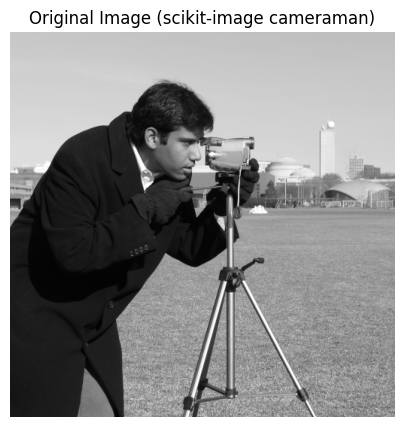

In [5]:
if HAS_SKIMAGE:
    try:
        gray_image = data.camera() 
        print("Loaded standard 'cameraman' image using scikit-image.")
        image_source = 'scikit-image cameraman'
    except Exception as e:
        print(f"Error loading 'cameraman' from scikit-image: {e}")
        print("Falling back to loading from file.")
        HAS_SKIMAGE = False

if gray_image is None and not HAS_SKIMAGE:
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at '{image_path}'")
    else:
        gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image_source = image_path
        if gray_image is None:
            print(f"Error: Could not load image from file '{image_path}' using OpenCV.")
        else:
            print(f"Loaded image from file: '{image_path}'")


if gray_image is None:
    print("\nERROR: Image loading failed. Cannot proceed.")

else:
    print(f"Image loaded successfully. Shape: {gray_image.shape}, Type: {gray_image.dtype}")

    plt.figure(figsize=(5, 5))
    plt.imshow(gray_image, cmap='gray')
    plt.title(f'Original Image ({image_source})')
    plt.axis('off')
    plt.show()

In [6]:
if gray_image is not None:
    gaussian_noisy = add_gaussian_noise(gray_image, sigma=gaussian_sigma)
    salt_pepper_noisy = add_salt_and_pepper_noise(gray_image, amount=sp_amount, salt_vs_pepper=sp_ratio)
    speckle_noisy = add_speckle_noise(gray_image, sigma=speckle_sigma)
    print("Noise added successfully.")
else:
    print("Skipping noise addition because the image was not loaded.")
    gaussian_noisy, salt_pepper_noisy, speckle_noisy = None, None, None

Noise added successfully.


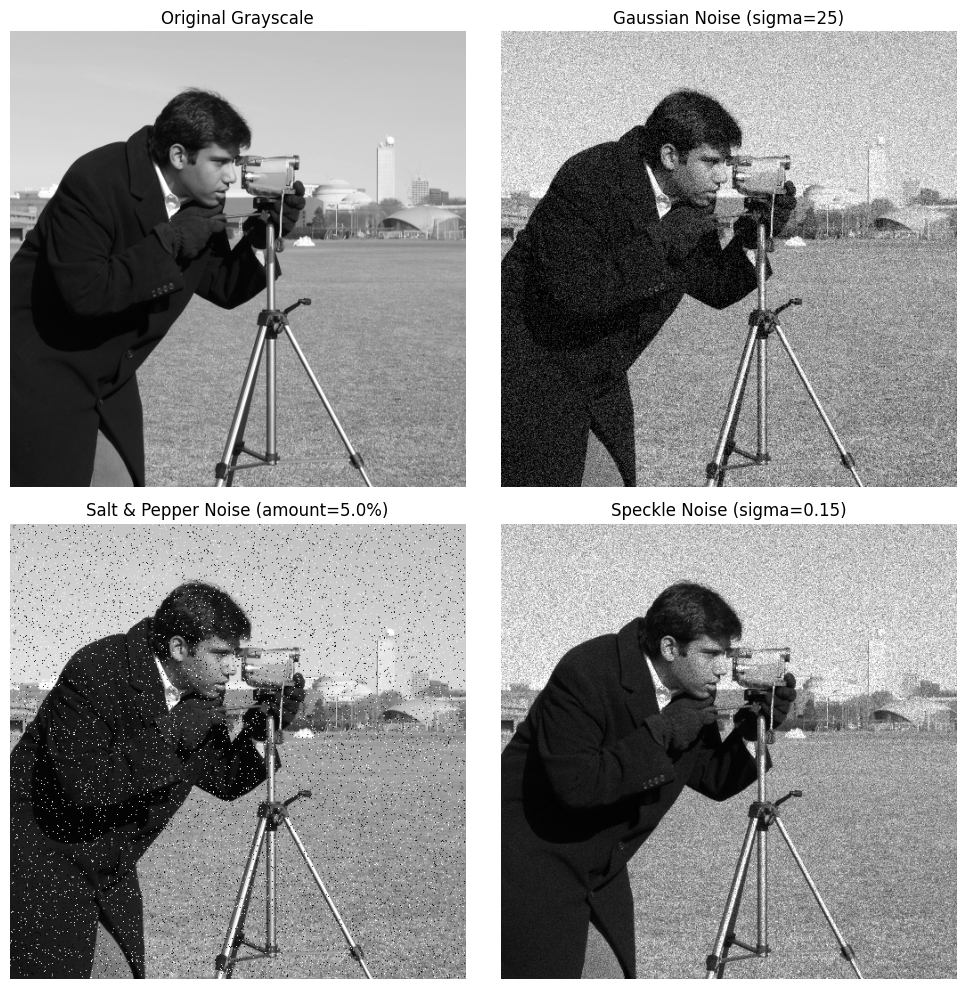

In [7]:
if gray_image is not None and gaussian_noisy is not None:
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    cmap = 'gray'

    axes[0, 0].imshow(gray_image, cmap=cmap)
    axes[0, 0].set_title('Original Grayscale')
    axes[0, 0].axis('off') 
    axes[0, 1].imshow(gaussian_noisy, cmap=cmap)
    axes[0, 1].set_title(f'Gaussian Noise (sigma={gaussian_sigma})')
    axes[0, 1].axis('off')
    axes[1, 0].imshow(salt_pepper_noisy, cmap=cmap)
    axes[1, 0].set_title(f'Salt & Pepper Noise (amount={sp_amount*100:.1f}%)')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(speckle_noisy, cmap=cmap)
    axes[1, 1].set_title(f'Speckle Noise (sigma={speckle_sigma})')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
if gray_image is not None:
    print("Applying filters manually (for comparison)...")
    # Filters for Gaussian noisy image
    gauss_filtered_g = cv2.GaussianBlur(gaussian_noisy, gaussian_ksize, 0)
    median_filtered_g = cv2.medianBlur(gaussian_noisy, median_ksize)
    bilateral_filtered_g = cv2.bilateralFilter(gaussian_noisy, bilateral_d, bilateral_sigma_color, bilateral_sigma_space)
    # Filters for Salt & Pepper noisy image
    gauss_filtered_sp = cv2.GaussianBlur(salt_pepper_noisy, gaussian_ksize, 0)
    median_filtered_sp = cv2.medianBlur(salt_pepper_noisy, median_ksize)
    bilateral_filtered_sp = cv2.bilateralFilter(salt_pepper_noisy, bilateral_d, bilateral_sigma_color, bilateral_sigma_space)
    # Filters for Speckle noisy image
    gauss_filtered_s = cv2.GaussianBlur(speckle_noisy, gaussian_ksize, 0)
    median_filtered_s = cv2.medianBlur(speckle_noisy, median_ksize)
    bilateral_filtered_s = cv2.bilateralFilter(speckle_noisy, bilateral_d, bilateral_sigma_color, bilateral_sigma_space)
    print("Manual filtering complete.")

Applying filters manually (for comparison)...
Manual filtering complete.


In [9]:
if gray_image is not None:
    print("\nApplying adaptive filtering (Detection + Selection)...")
    print("--- Processing Gaussian Noisy Image ---")
    g_detected_noise, g_selected_filter, g_adaptive_filtered = detect_noise_and_filter(
        gaussian_noisy, sp_detect_threshold, speckle_detect_corr, local_stat_block_size,
        gaussian_ksize, median_ksize, bilateral_d, bilateral_sigma_color, bilateral_sigma_space
    )
    print("\n--- Processing Salt & Pepper Noisy Image ---")
    sp_detected_noise, sp_selected_filter, sp_adaptive_filtered = detect_noise_and_filter(
        salt_pepper_noisy, sp_detect_threshold, speckle_detect_corr, local_stat_block_size,
        gaussian_ksize, median_ksize, bilateral_d, bilateral_sigma_color, bilateral_sigma_space
    )
    print("\n--- Processing Speckle Noisy Image ---")
    s_detected_noise, s_selected_filter, s_adaptive_filtered = detect_noise_and_filter(
        speckle_noisy, sp_detect_threshold, speckle_detect_corr, local_stat_block_size,
        gaussian_ksize, median_ksize, bilateral_d, bilateral_sigma_color, bilateral_sigma_space
    )
    print("\nAdaptive filtering complete.")


Applying adaptive filtering (Detection + Selection)...
--- Processing Gaussian Noisy Image ---
Detected Salt & Pepper (6.85% extreme pixels). Applying Median Filter...

--- Processing Salt & Pepper Noisy Image ---
Detected Salt & Pepper (4.98% extreme pixels). Applying Median Filter...

--- Processing Speckle Noisy Image ---
Detected Salt & Pepper (2.15% extreme pixels). Applying Median Filter...

Adaptive filtering complete.


Displaying main comparison plot...


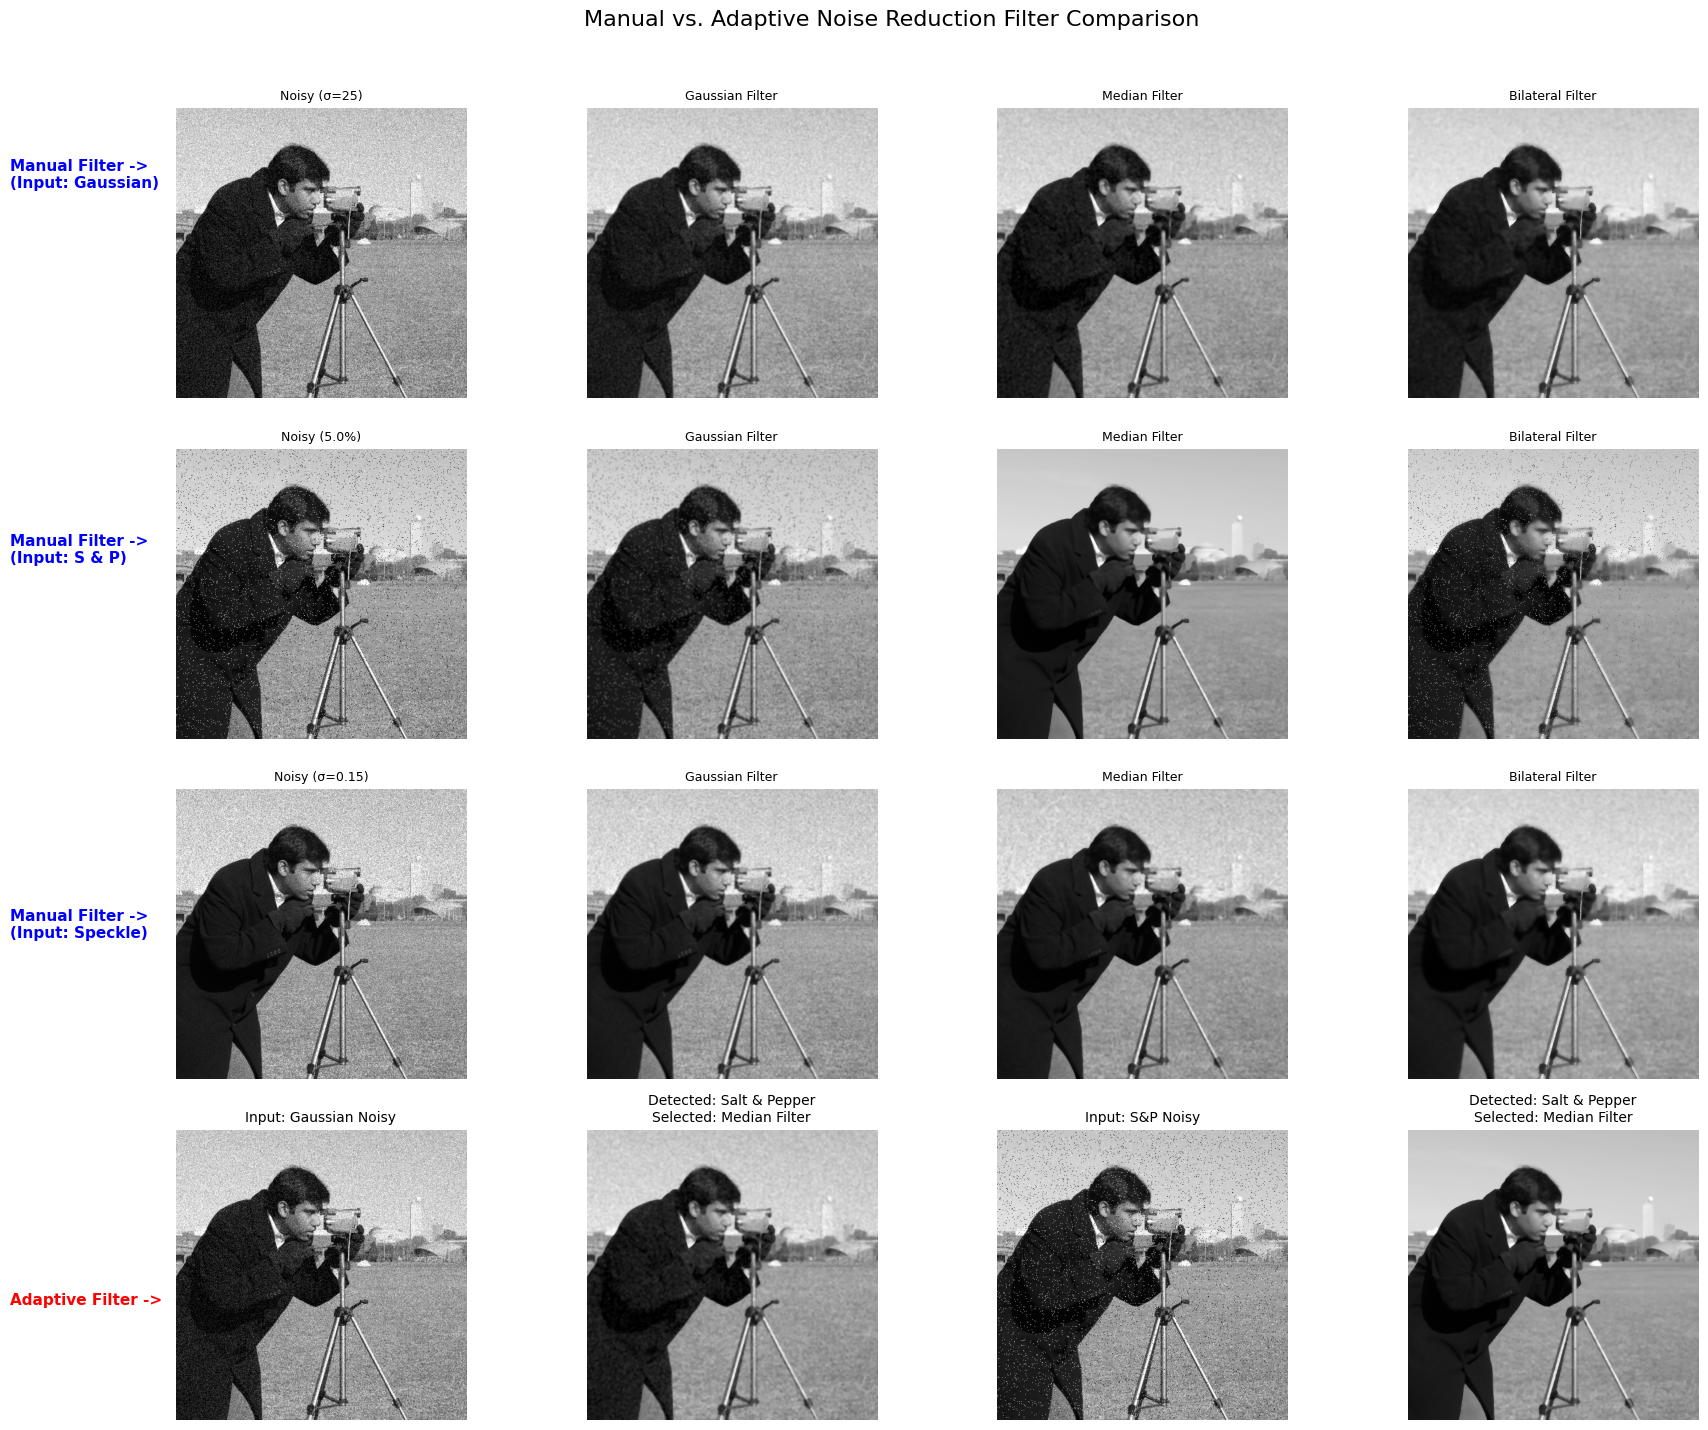

Displaying adaptive result for Speckle input...


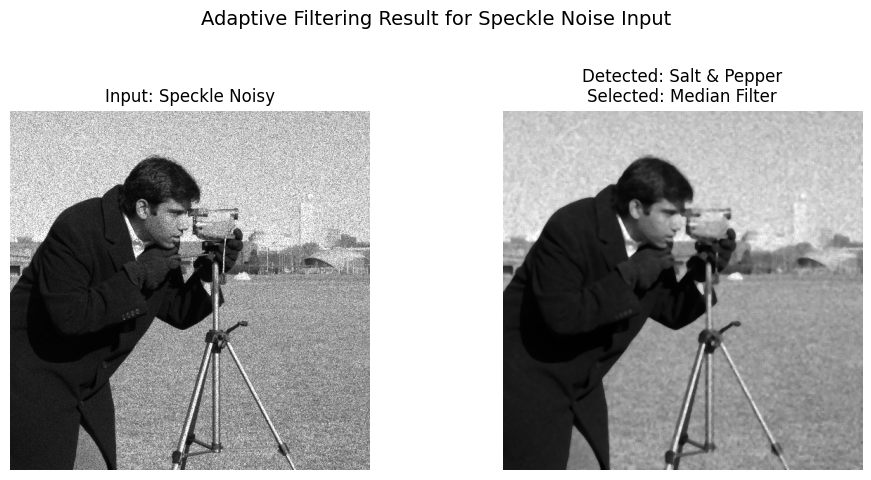

In [ ]:
if gray_image is not None:
    fig, axes = plt.subplots(4, 4, figsize=(18, 15))
    cmap = 'gray'
    label_fontsize = 11
    title_fontsize = 9
    adaptive_title_fontsize = 10

    manual_color = 'blue'
    adaptive_color = 'red'

    fig.text(0.01, 0.87, 'Manual Filter ->\n(Input: Gaussian)', fontsize=label_fontsize, va='center', ha='left', weight='bold', color=manual_color)
    axes[0, 0].imshow(gaussian_noisy, cmap=cmap); axes[0, 0].set_title(f'Noisy (σ={gaussian_sigma})', fontsize=title_fontsize); axes[0, 0].axis('off')
    axes[0, 1].imshow(gauss_filtered_g, cmap=cmap); axes[0, 1].set_title(f'Gaussian Filter', fontsize=title_fontsize); axes[0, 1].axis('off')
    axes[0, 2].imshow(median_filtered_g, cmap=cmap); axes[0, 2].set_title(f'Median Filter', fontsize=title_fontsize); axes[0, 2].axis('off')
    axes[0, 3].imshow(bilateral_filtered_g, cmap=cmap); axes[0, 3].set_title(f'Bilateral Filter', fontsize=title_fontsize); axes[0, 3].axis('off')

    fig.text(0.01, 0.62, 'Manual Filter ->\n(Input: S & P)', fontsize=label_fontsize, va='center', ha='left', weight='bold', color=manual_color)
    axes[1, 0].imshow(salt_pepper_noisy, cmap=cmap); axes[1, 0].set_title(f'Noisy ({sp_amount*100:.1f}%)', fontsize=title_fontsize); axes[1, 0].axis('off')
    axes[1, 1].imshow(gauss_filtered_sp, cmap=cmap); axes[1, 1].set_title(f'Gaussian Filter', fontsize=title_fontsize); axes[1, 1].axis('off')
    axes[1, 2].imshow(median_filtered_sp, cmap=cmap); axes[1, 2].set_title(f'Median Filter', fontsize=title_fontsize); axes[1, 2].axis('off')
    axes[1, 3].imshow(bilateral_filtered_sp, cmap=cmap); axes[1, 3].set_title(f'Bilateral Filter', fontsize=title_fontsize); axes[1, 3].axis('off')

    fig.text(0.01, 0.37, 'Manual Filter ->\n(Input: Speckle)', fontsize=label_fontsize, va='center', ha='left', weight='bold', color=manual_color)
    axes[2, 0].imshow(speckle_noisy, cmap=cmap); axes[2, 0].set_title(f'Noisy (σ={speckle_sigma})', fontsize=title_fontsize); axes[2, 0].axis('off')
    axes[2, 1].imshow(gauss_filtered_s, cmap=cmap); axes[2, 1].set_title(f'Gaussian Filter', fontsize=title_fontsize); axes[2, 1].axis('off')
    axes[2, 2].imshow(median_filtered_s, cmap=cmap); axes[2, 2].set_title(f'Median Filter', fontsize=title_fontsize); axes[2, 2].axis('off')
    axes[2, 3].imshow(bilateral_filtered_s, cmap=cmap); axes[2, 3].set_title(f'Bilateral Filter', fontsize=title_fontsize); axes[2, 3].axis('off')

    fig.text(0.01, 0.12, 'Adaptive Filter ->', fontsize=label_fontsize, va='center', ha='left', weight='bold', color=adaptive_color)

    axes[3, 0].imshow(gaussian_noisy, cmap=cmap)
    axes[3, 0].set_title(f'Input: Gaussian Noisy', fontsize=adaptive_title_fontsize)
    axes[3, 0].axis('off')
    axes[3, 1].imshow(g_adaptive_filtered, cmap=cmap)
    axes[3, 1].set_title(f'Detected: {g_detected_noise}\nSelected: {g_selected_filter}', fontsize=adaptive_title_fontsize)
    axes[3, 1].axis('off')

    axes[3, 2].imshow(salt_pepper_noisy, cmap=cmap)
    axes[3, 2].set_title(f'Input: S&P Noisy', fontsize=adaptive_title_fontsize)
    axes[3, 2].axis('off')
    axes[3, 3].imshow(sp_adaptive_filtered, cmap=cmap)
    axes[3, 3].set_title(f'Detected: {sp_detected_noise}\nSelected: {sp_selected_filter}', fontsize=adaptive_title_fontsize)
    axes[3, 3].axis('off')

    fig.suptitle('Manual vs. Adaptive Noise Reduction Filter Comparison', fontsize=16)
    plt.tight_layout(rect=[0.05, 0.03, 1, 0.96])
    print("Displaying main comparison plot...")
    plt.show()

    fig2, axes2 = plt.subplots(1, 2, figsize=(10, 5))
    fig2.suptitle("Adaptive Filtering Result for Speckle Noise Input", fontsize=14)

    axes2[0].imshow(speckle_noisy, cmap=cmap)
    axes2[0].set_title('Input: Speckle Noisy')
    axes2[0].axis('off')

    axes2[1].imshow(s_adaptive_filtered, cmap=cmap)
    axes2[1].set_title(f'Detected: {s_detected_noise}\nSelected: {s_selected_filter}')
    axes2[1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust rect for suptitle
    print("Displaying adaptive result for Speckle input...")
    plt.show()